In [2]:
import os.path as os

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, Linear, PointNetConv, fps, global_max_pool, radius
from torch_geometric.typing import WITH_TORCH_CLUSTER

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# data set imports
import dataset_utils as du
from torch.utils.data import DataLoader, random_split

B = 10

# load dataset
dataset = du.SDFDataset("./cars100")
train_percent = 0.9

# split dataset into training and validation sets
train_size = int(train_percent * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=B, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Train dataset size: 90, Validation dataset size: 10


In [9]:
def process_batch(batch, np_in=2048, np_q=15000):
    B, N, _ = batch.shape
    coords = batch[..., :3]   # [B, N, 3]
    sdfs   = batch[...,  3]   # [B, N]

    print(B, N)

    idx_in = torch.stack([
        torch.randperm(N, device=batch.device)[:np_in]
        for _ in range(B)
    ], dim=0)               # [B, np_in] # random samples

    idx_q  = torch.stack([
        torch.randperm(N, device=batch.device)[:np_q]
        for _ in range(B)
    ], dim=0)               # [B, np_q] # random samples

    batch_ids = torch.arange(B, device=batch.device).unsqueeze(1)
    pos = coords[batch_ids, idx_in]       # [B, np_in,  3]
    x = sdfs[batch_ids, idx_in].unsqueeze(-1)  # [B, np_in, 1]

    query_pos = coords[batch_ids, idx_q]        # [B, np_q,  3]
    query_sdf = sdfs[batch_ids, idx_q].unsqueeze(-1)          # [B, np_q, 1]

    pos = pos.reshape(-1, 3).contiguous()      # [B*np_in, 3]
    x = x.reshape(-1, 1).contiguous()        # [B*np_in, 1]
    batch_idx = batch_ids.repeat(1, np_in)           # [B, np_in]
    batch_idx = batch_idx.reshape(-1).contiguous()   # [B*np_in]
    
    return x.to(device), pos.to(device), batch_idx.to(device), query_pos.to(device), query_sdf.to(device)

Define Layers and Model

In [10]:
class SAModule(torch.nn.Module):
    def __init__(self, ratio, r, nn):
        super().__init__()
        self.ratio = ratio
        self.r = r
        self.conv = PointNetConv(nn, add_self_loops=False)

    def forward(self, x, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=128)
        edge_index = torch.stack([col, row], dim=0)
        x_dst = None if x is None else x[idx]
        x = self.conv((x, x_dst), (pos, pos[idx]), edge_index)
        pos, batch = pos[idx], batch[idx]
        return x, pos, batch


class GlobalSAModule(torch.nn.Module):
    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def forward(self, x, pos, batch):
        x = self.nn(torch.cat([x, pos], dim=1))
        x = global_max_pool(x, batch)
        pos = pos.new_zeros((x.size(0), 3))
        batch = torch.arange(x.size(0), device=batch.device)
        return x, pos, batch


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([4, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.5, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = GlobalSAModule(MLP([256 + 3, 256, 512, 1024]))

        self.encode = MLP([1024, 512], dropout=0.4, norm=None) # learn global features -> reduce to 512

        self.mlp_mu = MLP([512, 512], dropout=0.4, norm=None) # get mu
        self.mlp_logvar = MLP([512, 512], dropout=0.4, norm=None) # get logvar

        self.sdf1 = MLP([512 + 3, 256, 128], norm=None)
        self.sdf2 = MLP([128 + 3, 64, 1], norm=None)
        
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std) # std just gives dimension of tensor to give back
        return mu + epsilon * std

    def forward(self, x, pos, batch, query_pos):
        # encode shape
        sa0_out = (x, pos, batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        x, pos, batch = sa3_out # x latent encoding from pointnet
        
        # vae
        x = self.encode(x)
        mu = self.mlp_mu(x) # [1, 512]
        logvar = self.mlp_logvar(x) # [1, 512]
        x = self.reparametrize(mu, logvar) # [1, 512]
       
        # decoder
        x = torch.cat((x.reshape(B, -1, 512).repeat(1, query_pos.shape[1], 1), query_pos), dim=-1) # concatenate encoded shape with query positions) # [B, np_q, 515]
        x = self.sdf1(x) # [B, np_q, 128]
        x = torch.cat((x, query_pos), dim=-1) # [B, np_q, 131]
        x = self.sdf2(x) # [B, np_q, 1]
        out = torch.tanh(x) # [B, np_q, 1]

        return out, mu, logvar

Define Loss

In [ ]:
def loss_function(out, query_sdf, mu, logvar):
    mse_loss = F.mse_loss(out, query_sdf)  # L2 loss for SDF prediction
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence loss for latent distribution

    print(f'MSE Loss: {mse_loss:.4f}, KL Loss: {(kl_loss * 0.01):.4f}')

    return mse_loss + 0.01 * kl_loss

In [12]:
# test model
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch = next(iter(train_loader))
print(f'Batch shape: {batch.shape}')
x, pos, batch, query_pos, query_sdf = process_batch(batch)
print(f'pos shape: {pos.shape}, query_pos shape: {query_pos.shape}, query_sdf shape: {query_sdf.shape}, x shape: {x.shape}')

print(f'pos shape: {pos.shape}')
# forward pass
output, mu, logvar = model(x, pos, batch, query_pos)
# print output shape
print(f"Output shape: {output.shape}")

loss = loss_function(output, query_sdf, mu, logvar)
print(f'Loss: {loss.item()}')

Batch shape: torch.Size([10, 50000, 4])
10 50000
pos shape: torch.Size([20480, 3]), query_pos shape: torch.Size([10, 15000, 3]), query_sdf shape: torch.Size([10, 15000, 1]), x shape: torch.Size([20480, 1])
pos shape: torch.Size([20480, 3])
Output shape: torch.Size([10, 15000, 1])
MSE Loss: 0.0774, KL Loss: 3.3998
Loss: 3.4771409034729004


In [ ]:
def show_validation():
    model.eval()
    batch = next(iter(val_loader))
    print(batch.shape)
    x, pos, batch, query_pos, query_sdf = process_batch(batch)
    output, mu, logvar = model(x, pos, batch, query_pos)


    prediction = torch.cat((query_pos, output), dim=-1).detach().cpu()  # (1024, 3 + 1)
    truth = torch.cat((query_pos, query_sdf.unsqueeze(-1)), dim=-1).detach().cpu()  # (1024, 3 + 1)

    print("MODEL")
    du.visualize_sdf_3d(prediction)
    du.visualize_sdf_2d(prediction)
    print("TRUTH")
    du.visualize_sdf_3d(truth)
    du.visualize_sdf_2d(truth)

    loss = F.mse_loss(output.squeeze(-1), query_sdf)  # L1 loss for SDF prediction
    print("Validation Loss: {:.4f}".format(loss.item()))

show_validation()

  0%|          | 1/1000 [00:00<07:38,  2.18it/s]

MSE Loss: 0.0566, KL Loss: 0.1305
MSE Loss: 0.0485, KL Loss: 0.1877


  0%|          | 2/1000 [00:00<07:52,  2.11it/s]

MSE Loss: 0.0423, KL Loss: 0.1723


  0%|          | 4/1000 [00:01<07:53,  2.10it/s]

MSE Loss: 0.0417, KL Loss: 0.0894
MSE Loss: 0.0547, KL Loss: 0.0600


  1%|          | 6/1000 [00:02<07:56,  2.09it/s]

MSE Loss: 0.0454, KL Loss: 0.0378
MSE Loss: 0.0417, KL Loss: 0.0223


  1%|          | 8/1000 [00:03<07:59,  2.07it/s]

MSE Loss: 0.0431, KL Loss: 0.0210
MSE Loss: 0.0425, KL Loss: 0.0092


  1%|          | 9/1000 [00:04<07:58,  2.07it/s]

MSE Loss: 0.0411, KL Loss: 0.0060


  1%|          | 10/1000 [00:04<07:58,  2.07it/s]

MSE Loss: 0.0418, KL Loss: 0.0038


  1%|          | 11/1000 [00:05<08:00,  2.06it/s]

MSE Loss: 0.0405, KL Loss: 0.0038


  1%|          | 12/1000 [00:05<08:10,  2.01it/s]

MSE Loss: 0.0419, KL Loss: 0.0034


  1%|▏         | 14/1000 [00:06<08:19,  1.97it/s]

MSE Loss: 0.0415, KL Loss: 0.0032
MSE Loss: 0.0411, KL Loss: 0.0028


  2%|▏         | 16/1000 [00:07<08:05,  2.03it/s]

MSE Loss: 0.0395, KL Loss: 0.0030
MSE Loss: 0.0405, KL Loss: 0.0025


  2%|▏         | 17/1000 [00:08<07:59,  2.05it/s]

MSE Loss: 0.0411, KL Loss: 0.0024


  2%|▏         | 18/1000 [00:08<07:58,  2.05it/s]

MSE Loss: 0.0400, KL Loss: 0.0023


  2%|▏         | 19/1000 [00:09<07:56,  2.06it/s]

MSE Loss: 0.0388, KL Loss: 0.0021


  2%|▏         | 20/1000 [00:09<07:54,  2.06it/s]

Loss: 0.0409
MSE Loss: 0.0381, KL Loss: 0.0020


  2%|▏         | 21/1000 [00:10<07:56,  2.05it/s]

MSE Loss: 0.0391, KL Loss: 0.0019


  2%|▏         | 22/1000 [00:10<08:13,  1.98it/s]

MSE Loss: 0.0390, KL Loss: 0.0017


  2%|▏         | 23/1000 [00:11<08:10,  1.99it/s]

MSE Loss: 0.0406, KL Loss: 0.0017


  2%|▎         | 25/1000 [00:12<07:58,  2.04it/s]

MSE Loss: 0.0404, KL Loss: 0.0016


  3%|▎         | 26/1000 [00:12<07:52,  2.06it/s]

MSE Loss: 0.0405, KL Loss: 0.0016


  3%|▎         | 27/1000 [00:13<07:50,  2.07it/s]

MSE Loss: 0.0382, KL Loss: 0.0018
MSE Loss: 0.0376, KL Loss: 0.0014


  3%|▎         | 28/1000 [00:13<07:47,  2.08it/s]

MSE Loss: 0.0378, KL Loss: 0.0013


  3%|▎         | 29/1000 [00:14<07:45,  2.09it/s]

MSE Loss: 0.0386, KL Loss: 0.0013


  3%|▎         | 31/1000 [00:15<07:53,  2.05it/s]

MSE Loss: 0.0384, KL Loss: 0.0013
MSE Loss: 0.0383, KL Loss: 0.0052


  3%|▎         | 33/1000 [00:16<07:42,  2.09it/s]

MSE Loss: 0.0384, KL Loss: 0.0016
MSE Loss: 0.0386, KL Loss: 0.0009


  3%|▎         | 34/1000 [00:16<07:42,  2.09it/s]

MSE Loss: 0.0382, KL Loss: 0.0010


  4%|▎         | 36/1000 [00:17<07:37,  2.11it/s]

MSE Loss: 0.0380, KL Loss: 0.0010
MSE Loss: 0.0384, KL Loss: 0.0009


  4%|▍         | 38/1000 [00:18<07:47,  2.06it/s]

MSE Loss: 0.0383, KL Loss: 0.0008


  4%|▍         | 39/1000 [00:18<07:50,  2.04it/s]

MSE Loss: 0.0381, KL Loss: 0.0008


  4%|▍         | 40/1000 [00:19<07:43,  2.07it/s]

MSE Loss: 0.0381, KL Loss: 0.0007
Loss: 0.0388
MSE Loss: 0.0381, KL Loss: 0.0007


  4%|▍         | 42/1000 [00:20<07:44,  2.06it/s]

MSE Loss: 0.0395, KL Loss: 0.0005


  4%|▍         | 43/1000 [00:20<07:41,  2.07it/s]

MSE Loss: 0.0383, KL Loss: 0.0010
MSE Loss: 0.0377, KL Loss: 0.0006


  4%|▍         | 45/1000 [00:21<07:34,  2.10it/s]

MSE Loss: 0.0379, KL Loss: 0.0005


  5%|▍         | 46/1000 [00:22<08:00,  1.98it/s]

MSE Loss: 0.0378, KL Loss: 0.0005


  5%|▍         | 47/1000 [00:22<07:53,  2.01it/s]

MSE Loss: 0.0404, KL Loss: 0.0005
MSE Loss: 0.0375, KL Loss: 0.0005


  5%|▍         | 48/1000 [00:23<07:46,  2.04it/s]

MSE Loss: 0.0389, KL Loss: 0.0009


  5%|▍         | 49/1000 [00:23<07:44,  2.05it/s]

MSE Loss: 0.0373, KL Loss: 0.0004


  5%|▌         | 50/1000 [00:24<07:40,  2.06it/s]

MSE Loss: 0.0374, KL Loss: 0.0020


  5%|▌         | 51/1000 [00:25<08:41,  1.82it/s]

MSE Loss: 0.0375, KL Loss: 0.0002


  5%|▌         | 52/1000 [00:26<12:14,  1.29it/s]

MSE Loss: 0.0380, KL Loss: 0.0003


  5%|▌         | 54/1000 [00:27<10:02,  1.57it/s]

MSE Loss: 0.0397, KL Loss: 0.0003
MSE Loss: 0.0373, KL Loss: 0.0002


  6%|▌         | 56/1000 [00:28<08:52,  1.77it/s]

MSE Loss: 0.0375, KL Loss: 0.0001


  6%|▌         | 57/1000 [00:28<08:25,  1.87it/s]

MSE Loss: 0.0373, KL Loss: 0.0001


  6%|▌         | 58/1000 [00:29<08:08,  1.93it/s]

MSE Loss: 0.0375, KL Loss: 0.0002
MSE Loss: 0.0384, KL Loss: 0.0002


  6%|▌         | 59/1000 [00:29<08:25,  1.86it/s]

MSE Loss: 0.0368, KL Loss: 0.0001


  6%|▌         | 60/1000 [00:30<08:05,  1.94it/s]

Loss: 0.0369
MSE Loss: 0.0378, KL Loss: 0.0001


  6%|▌         | 61/1000 [00:30<07:58,  1.96it/s]

MSE Loss: 0.0366, KL Loss: 0.0002


  6%|▋         | 63/1000 [00:31<07:45,  2.01it/s]

MSE Loss: 0.0369, KL Loss: 0.0001
MSE Loss: 0.0376, KL Loss: 0.0001


  6%|▋         | 64/1000 [00:32<07:40,  2.03it/s]

MSE Loss: 0.0368, KL Loss: 0.0001


  6%|▋         | 65/1000 [00:32<07:42,  2.02it/s]

MSE Loss: 0.0408, KL Loss: 0.0001


  7%|▋         | 66/1000 [00:33<07:36,  2.04it/s]

MSE Loss: 0.0374, KL Loss: 0.0001


  7%|▋         | 68/1000 [00:34<07:33,  2.06it/s]

MSE Loss: 0.0374, KL Loss: 0.0001
MSE Loss: 0.0371, KL Loss: 0.0001


  7%|▋         | 70/1000 [00:35<07:26,  2.08it/s]

MSE Loss: 0.0375, KL Loss: 0.0001
MSE Loss: 0.0372, KL Loss: 0.0000


  7%|▋         | 71/1000 [00:35<07:21,  2.11it/s]

MSE Loss: 0.0367, KL Loss: 0.0008


  7%|▋         | 73/1000 [00:36<07:21,  2.10it/s]

MSE Loss: 0.0377, KL Loss: 0.0001


  7%|▋         | 74/1000 [00:37<07:19,  2.11it/s]

MSE Loss: 0.0367, KL Loss: 0.0000
MSE Loss: 0.0360, KL Loss: 0.0000


  8%|▊         | 75/1000 [00:37<07:28,  2.06it/s]

MSE Loss: 0.0360, KL Loss: 0.0000


  8%|▊         | 76/1000 [00:38<07:25,  2.07it/s]

MSE Loss: 0.0359, KL Loss: 0.0001


  8%|▊         | 77/1000 [00:38<07:27,  2.06it/s]

MSE Loss: 0.0364, KL Loss: 0.0000


  8%|▊         | 79/1000 [00:39<07:25,  2.07it/s]

MSE Loss: 0.0372, KL Loss: 0.0001
MSE Loss: 0.0366, KL Loss: 0.0000


  8%|▊         | 80/1000 [00:39<07:23,  2.08it/s]

Loss: 0.0366
MSE Loss: 0.0365, KL Loss: 0.0001


  8%|▊         | 81/1000 [00:40<07:24,  2.07it/s]

MSE Loss: 0.0373, KL Loss: 0.0000


  8%|▊         | 83/1000 [00:41<07:40,  1.99it/s]

MSE Loss: 0.0358, KL Loss: 0.0001
MSE Loss: 0.0380, KL Loss: 0.0000


  8%|▊         | 84/1000 [00:41<07:32,  2.03it/s]

MSE Loss: 0.0404, KL Loss: 0.0000


  8%|▊         | 85/1000 [00:42<07:30,  2.03it/s]

MSE Loss: 0.0361, KL Loss: 0.0000


  9%|▊         | 86/1000 [00:42<07:23,  2.06it/s]

MSE Loss: 0.0355, KL Loss: 0.0000


  9%|▊         | 87/1000 [00:43<07:22,  2.06it/s]

MSE Loss: 0.0373, KL Loss: 0.0000


  9%|▉         | 88/1000 [00:43<07:17,  2.08it/s]

MSE Loss: 0.0369, KL Loss: 0.0000


  9%|▉         | 90/1000 [00:44<07:24,  2.05it/s]

MSE Loss: 0.0360, KL Loss: 0.0000
MSE Loss: 0.0364, KL Loss: 0.0000


  9%|▉         | 91/1000 [00:45<07:24,  2.04it/s]

MSE Loss: 0.0382, KL Loss: 0.0000


  9%|▉         | 93/1000 [00:46<07:16,  2.08it/s]

MSE Loss: 0.0359, KL Loss: 0.0000
MSE Loss: 0.0381, KL Loss: 0.0000


  9%|▉         | 94/1000 [00:46<07:15,  2.08it/s]

MSE Loss: 0.0364, KL Loss: 0.0000


 10%|▉         | 95/1000 [00:47<07:17,  2.07it/s]

MSE Loss: 0.0371, KL Loss: 0.0000


 10%|▉         | 96/1000 [00:47<07:14,  2.08it/s]

MSE Loss: 0.0355, KL Loss: 0.0000


 10%|▉         | 97/1000 [00:48<07:41,  1.96it/s]

MSE Loss: 0.0398, KL Loss: 0.0000


 10%|▉         | 98/1000 [00:48<07:32,  2.00it/s]

MSE Loss: 0.0359, KL Loss: 0.0000


 10%|▉         | 99/1000 [00:49<07:25,  2.02it/s]

MSE Loss: 0.0355, KL Loss: 0.0000
Loss: 0.0355
torch.Size([1, 30000, 4])
MODEL


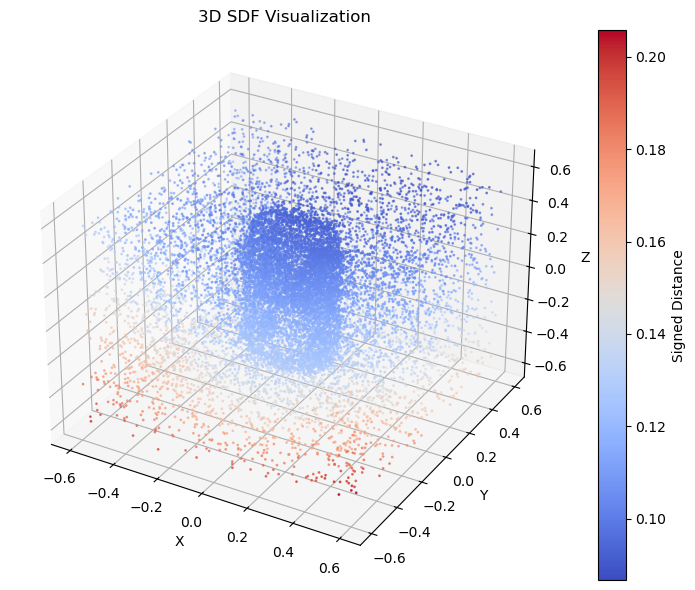

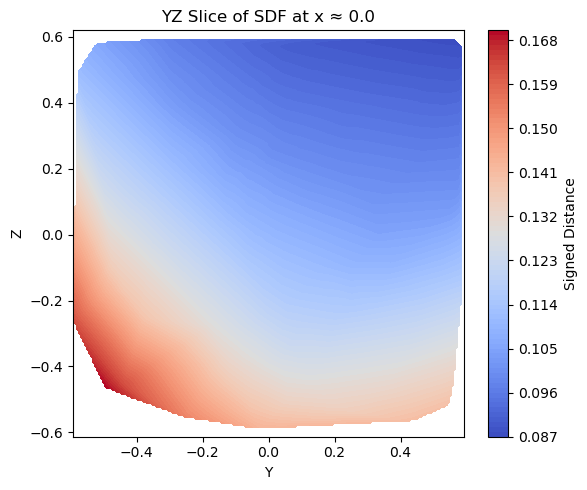

TRUTH


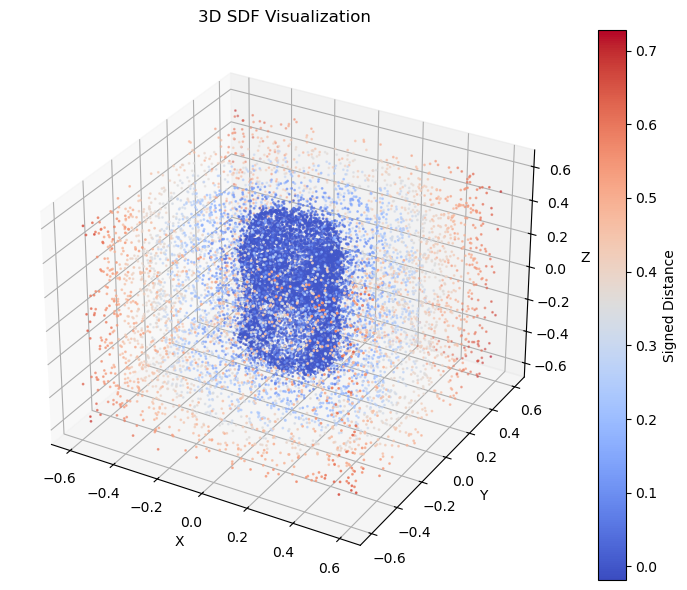

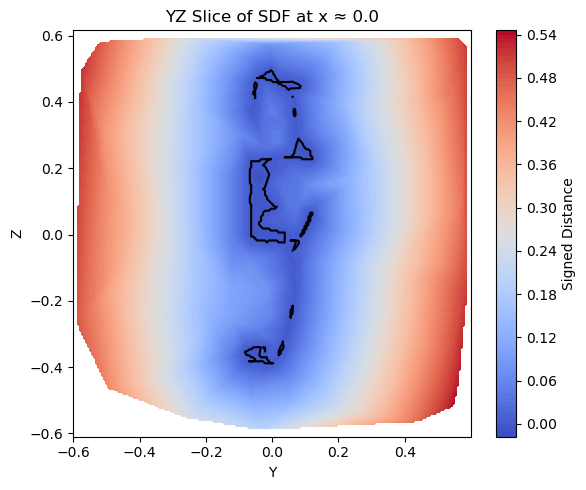

 10%|█         | 100/1000 [00:51<15:22,  1.03s/it]

Validation Loss: 0.0361
MSE Loss: 0.0354, KL Loss: 0.0000


 10%|█         | 101/1000 [00:52<13:39,  1.10it/s]

MSE Loss: 0.0358, KL Loss: 0.0000


 10%|█         | 102/1000 [00:52<11:43,  1.28it/s]

MSE Loss: 0.0364, KL Loss: 0.0000


 10%|█         | 103/1000 [00:53<10:29,  1.43it/s]

MSE Loss: 0.0363, KL Loss: 0.0000


 10%|█         | 104/1000 [00:53<09:31,  1.57it/s]

MSE Loss: 0.0353, KL Loss: 0.0000


 10%|█         | 105/1000 [00:54<08:58,  1.66it/s]

MSE Loss: 0.0356, KL Loss: 0.0000


 11%|█         | 106/1000 [00:54<08:30,  1.75it/s]

MSE Loss: 0.0351, KL Loss: 0.0000


 11%|█         | 107/1000 [00:55<08:07,  1.83it/s]

MSE Loss: 0.0360, KL Loss: 0.0000


 11%|█         | 108/1000 [00:55<08:27,  1.76it/s]

MSE Loss: 0.0354, KL Loss: 0.0000


 11%|█         | 109/1000 [00:56<08:08,  1.83it/s]

MSE Loss: 0.0353, KL Loss: 0.0000


 11%|█         | 110/1000 [00:56<07:53,  1.88it/s]

MSE Loss: 0.0343, KL Loss: 0.0000


 11%|█         | 112/1000 [00:57<07:31,  1.97it/s]

MSE Loss: 0.0351, KL Loss: 0.0000
MSE Loss: 0.0349, KL Loss: 0.0000


 11%|█▏        | 113/1000 [00:58<07:36,  1.94it/s]

MSE Loss: 0.0351, KL Loss: 0.0000


 11%|█▏        | 114/1000 [00:58<07:30,  1.97it/s]

MSE Loss: 0.0354, KL Loss: 0.0000


 12%|█▏        | 115/1000 [01:02<20:27,  1.39s/it]

MSE Loss: 0.0349, KL Loss: 0.0000


 12%|█▏        | 116/1000 [01:05<28:50,  1.96s/it]

MSE Loss: 0.0340, KL Loss: 0.0000


 12%|█▏        | 117/1000 [01:08<33:57,  2.31s/it]

MSE Loss: 0.0370, KL Loss: 0.0000


 12%|█▏        | 118/1000 [01:11<35:02,  2.38s/it]

MSE Loss: 0.0350, KL Loss: 0.0000


 12%|█▏        | 119/1000 [01:11<26:38,  1.81s/it]

MSE Loss: 0.0351, KL Loss: 0.0000


 12%|█▏        | 120/1000 [01:12<20:48,  1.42s/it]

Loss: 0.0352
MSE Loss: 0.0353, KL Loss: 0.0000


 12%|█▏        | 121/1000 [01:12<16:53,  1.15s/it]

MSE Loss: 0.0355, KL Loss: 0.0000


 12%|█▏        | 122/1000 [01:13<14:03,  1.04it/s]

MSE Loss: 0.0356, KL Loss: 0.0000


 12%|█▏        | 123/1000 [01:13<12:05,  1.21it/s]

MSE Loss: 0.0345, KL Loss: 0.0000


 12%|█▏        | 124/1000 [01:14<10:37,  1.37it/s]

MSE Loss: 0.0345, KL Loss: 0.0000


 12%|█▎        | 125/1000 [01:14<09:41,  1.50it/s]

MSE Loss: 0.0347, KL Loss: 0.0000


 13%|█▎        | 126/1000 [01:15<08:58,  1.62it/s]

MSE Loss: 0.0343, KL Loss: 0.0000


 13%|█▎        | 127/1000 [01:15<08:27,  1.72it/s]

MSE Loss: 0.0336, KL Loss: 0.0000


 13%|█▎        | 128/1000 [01:16<08:05,  1.80it/s]

MSE Loss: 0.0339, KL Loss: 0.0000


 13%|█▎        | 129/1000 [01:16<07:46,  1.87it/s]

MSE Loss: 0.0330, KL Loss: 0.0000


 13%|█▎        | 130/1000 [01:17<07:33,  1.92it/s]

MSE Loss: 0.0366, KL Loss: 0.0000


 13%|█▎        | 131/1000 [01:17<07:28,  1.94it/s]

MSE Loss: 0.0337, KL Loss: 0.0000


 13%|█▎        | 132/1000 [01:18<07:24,  1.95it/s]

MSE Loss: 0.0330, KL Loss: 0.0000


 13%|█▎        | 133/1000 [01:18<07:50,  1.84it/s]

MSE Loss: 0.0331, KL Loss: 0.0000


 13%|█▎        | 134/1000 [01:19<07:38,  1.89it/s]

MSE Loss: 0.0323, KL Loss: 0.0000


 14%|█▎        | 136/1000 [01:20<07:24,  1.95it/s]

MSE Loss: 0.0345, KL Loss: 0.0000
MSE Loss: 0.0324, KL Loss: 0.0000


 14%|█▎        | 137/1000 [01:20<07:13,  1.99it/s]

MSE Loss: 0.0355, KL Loss: 0.0000


 14%|█▍        | 138/1000 [01:21<07:12,  1.99it/s]

MSE Loss: 0.0321, KL Loss: 0.0000


 14%|█▍        | 139/1000 [01:21<07:09,  2.00it/s]

MSE Loss: 0.0336, KL Loss: 0.0000


 14%|█▍        | 140/1000 [01:22<07:04,  2.02it/s]

Loss: 0.0336
MSE Loss: 0.0329, KL Loss: 0.0000


 14%|█▍        | 141/1000 [01:22<07:44,  1.85it/s]

MSE Loss: 0.0320, KL Loss: 0.0000


 14%|█▍        | 143/1000 [01:23<07:21,  1.94it/s]

MSE Loss: 0.0333, KL Loss: 0.0000
MSE Loss: 0.0332, KL Loss: 0.0000


 14%|█▍        | 144/1000 [01:24<07:13,  1.98it/s]

MSE Loss: 0.0343, KL Loss: 0.0000


 14%|█▍        | 145/1000 [01:24<07:11,  1.98it/s]

MSE Loss: 0.0330, KL Loss: 0.0000


 15%|█▍        | 146/1000 [01:25<07:06,  2.00it/s]

MSE Loss: 0.0320, KL Loss: 0.0000


 15%|█▍        | 147/1000 [01:25<07:04,  2.01it/s]

MSE Loss: 0.0324, KL Loss: 0.0000


 15%|█▍        | 148/1000 [01:26<07:17,  1.95it/s]

MSE Loss: 0.0334, KL Loss: 0.0000


 15%|█▍        | 149/1000 [01:26<07:14,  1.96it/s]

MSE Loss: 0.0328, KL Loss: 0.0000


 15%|█▌        | 150/1000 [01:27<07:18,  1.94it/s]

MSE Loss: 0.0317, KL Loss: 0.0000


 15%|█▌        | 151/1000 [01:27<07:11,  1.97it/s]

MSE Loss: 0.0313, KL Loss: 0.0000


 15%|█▌        | 152/1000 [01:28<07:09,  1.98it/s]

MSE Loss: 0.0318, KL Loss: 0.0000


 15%|█▌        | 153/1000 [01:28<07:02,  2.00it/s]

MSE Loss: 0.0325, KL Loss: 0.0000


 15%|█▌        | 154/1000 [01:29<07:00,  2.01it/s]

MSE Loss: 0.0319, KL Loss: 0.0000


 16%|█▌        | 155/1000 [01:29<07:02,  2.00it/s]

MSE Loss: 0.0322, KL Loss: 0.0000


 16%|█▌        | 156/1000 [01:30<07:30,  1.87it/s]

MSE Loss: 0.0307, KL Loss: 0.0000


 16%|█▌        | 157/1000 [01:31<07:23,  1.90it/s]

MSE Loss: 0.0315, KL Loss: 0.0000


 16%|█▌        | 158/1000 [01:31<07:25,  1.89it/s]

MSE Loss: 0.0309, KL Loss: 0.0000


 16%|█▌        | 159/1000 [01:32<07:17,  1.92it/s]

MSE Loss: 0.0301, KL Loss: 0.0000


 16%|█▌        | 160/1000 [01:32<07:23,  1.90it/s]

Loss: 0.0301
MSE Loss: 0.0296, KL Loss: 0.0000


 16%|█▌        | 161/1000 [01:33<07:10,  1.95it/s]

MSE Loss: 0.0327, KL Loss: 0.0000


 16%|█▌        | 162/1000 [01:33<07:04,  1.98it/s]

MSE Loss: 0.0304, KL Loss: 0.0000


 16%|█▋        | 163/1000 [01:34<07:41,  1.81it/s]

MSE Loss: 0.0300, KL Loss: 0.0000


 16%|█▋        | 164/1000 [01:34<07:28,  1.86it/s]

MSE Loss: 0.0323, KL Loss: 0.0000


 16%|█▋        | 165/1000 [01:35<07:18,  1.90it/s]

MSE Loss: 0.0315, KL Loss: 0.0000


 17%|█▋        | 166/1000 [01:35<07:12,  1.93it/s]

MSE Loss: 0.0314, KL Loss: 0.0000


 17%|█▋        | 167/1000 [01:36<07:06,  1.95it/s]

MSE Loss: 0.0316, KL Loss: 0.0000


 17%|█▋        | 168/1000 [01:36<07:03,  1.96it/s]

MSE Loss: 0.0319, KL Loss: 0.0000


 17%|█▋        | 169/1000 [01:37<07:01,  1.97it/s]

MSE Loss: 0.0301, KL Loss: 0.0000


 17%|█▋        | 171/1000 [01:38<07:06,  1.94it/s]

MSE Loss: 0.0308, KL Loss: 0.0000


 17%|█▋        | 172/1000 [01:38<06:54,  2.00it/s]

MSE Loss: 0.0312, KL Loss: 0.0000
MSE Loss: 0.0296, KL Loss: 0.0000


 17%|█▋        | 174/1000 [01:39<06:44,  2.04it/s]

MSE Loss: 0.0302, KL Loss: 0.0000
MSE Loss: 0.0283, KL Loss: 0.0000


 18%|█▊        | 175/1000 [01:40<06:46,  2.03it/s]

MSE Loss: 0.0301, KL Loss: 0.0000


 18%|█▊        | 176/1000 [01:40<06:42,  2.05it/s]

MSE Loss: 0.0312, KL Loss: 0.0000


 18%|█▊        | 177/1000 [01:41<06:39,  2.06it/s]

MSE Loss: 0.0309, KL Loss: 0.0000


 18%|█▊        | 178/1000 [01:41<06:39,  2.06it/s]

MSE Loss: 0.0291, KL Loss: 0.0000


 18%|█▊        | 179/1000 [01:42<06:57,  1.97it/s]

MSE Loss: 0.0312, KL Loss: 0.0000


 18%|█▊        | 180/1000 [01:42<06:56,  1.97it/s]

Loss: 0.0312
MSE Loss: 0.0312, KL Loss: 0.0000


 18%|█▊        | 181/1000 [01:43<06:49,  2.00it/s]

MSE Loss: 0.0295, KL Loss: 0.0000


 18%|█▊        | 182/1000 [01:43<06:48,  2.00it/s]

MSE Loss: 0.0289, KL Loss: 0.0000


 18%|█▊        | 183/1000 [01:44<06:44,  2.02it/s]

MSE Loss: 0.0276, KL Loss: 0.0000


 18%|█▊        | 184/1000 [01:44<06:44,  2.02it/s]

MSE Loss: 0.0281, KL Loss: 0.0000


 18%|█▊        | 185/1000 [01:45<06:48,  2.00it/s]

MSE Loss: 0.0283, KL Loss: 0.0000


 19%|█▊        | 186/1000 [01:45<07:09,  1.89it/s]

MSE Loss: 0.0296, KL Loss: 0.0000


 19%|█▊        | 187/1000 [01:46<07:04,  1.91it/s]

MSE Loss: 0.0282, KL Loss: 0.0000


 19%|█▉        | 188/1000 [01:46<06:59,  1.94it/s]

MSE Loss: 0.0293, KL Loss: 0.0000


 19%|█▉        | 189/1000 [01:47<06:54,  1.96it/s]

MSE Loss: 0.0301, KL Loss: 0.0000


 19%|█▉        | 190/1000 [01:47<06:49,  1.98it/s]

MSE Loss: 0.0268, KL Loss: 0.0000


 19%|█▉        | 191/1000 [01:48<06:46,  1.99it/s]

MSE Loss: 0.0341, KL Loss: 0.0000


 19%|█▉        | 192/1000 [01:48<06:57,  1.94it/s]

MSE Loss: 0.0269, KL Loss: 0.0000


 19%|█▉        | 193/1000 [01:49<07:04,  1.90it/s]

MSE Loss: 0.0266, KL Loss: 0.0000


 19%|█▉        | 194/1000 [01:49<07:16,  1.85it/s]

MSE Loss: 0.0304, KL Loss: 0.0000


 20%|█▉        | 195/1000 [01:50<07:02,  1.91it/s]

MSE Loss: 0.0277, KL Loss: 0.0000


 20%|█▉        | 196/1000 [01:51<07:01,  1.91it/s]

MSE Loss: 0.0261, KL Loss: 0.0000


 20%|█▉        | 198/1000 [01:51<06:43,  1.99it/s]

MSE Loss: 0.0285, KL Loss: 0.0000
MSE Loss: 0.0260, KL Loss: 0.0000


 20%|█▉        | 199/1000 [01:52<06:39,  2.00it/s]

MSE Loss: 0.0271, KL Loss: 0.0000
Loss: 0.0271
torch.Size([1, 30000, 4])
MODEL


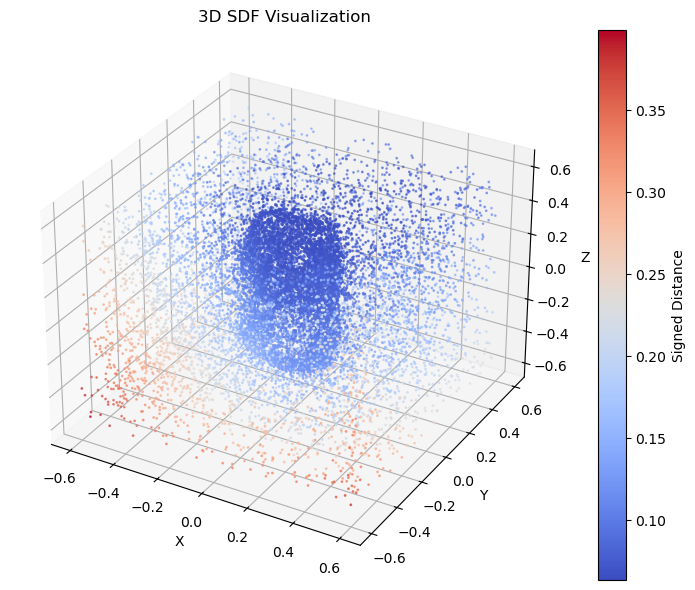

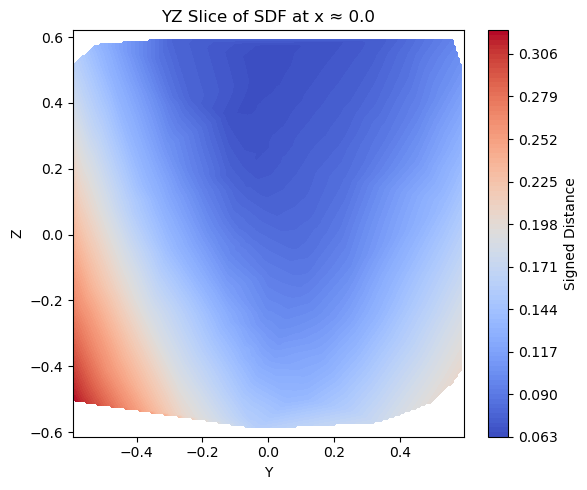

TRUTH


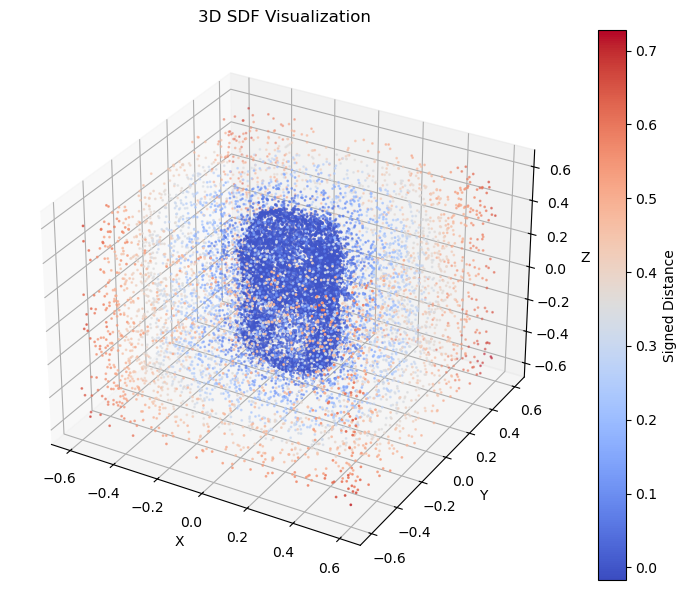

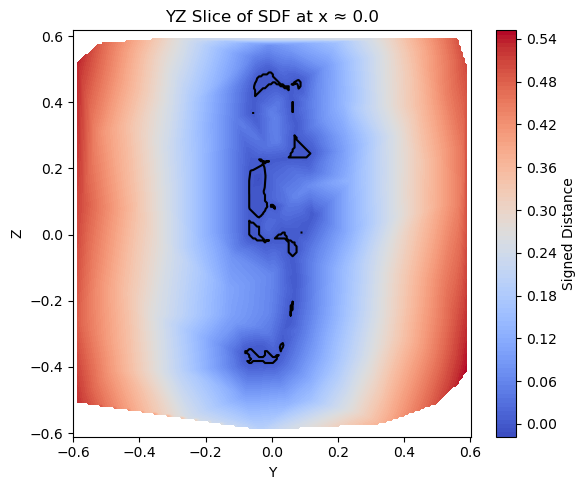

 20%|██        | 200/1000 [01:54<13:01,  1.02it/s]

Validation Loss: 0.0238


 20%|██        | 201/1000 [01:55<11:05,  1.20it/s]

MSE Loss: 0.0262, KL Loss: 0.0000
MSE Loss: 0.0275, KL Loss: 0.0000


 20%|██        | 202/1000 [01:55<09:49,  1.35it/s]

MSE Loss: 0.0285, KL Loss: 0.0000


 20%|██        | 203/1000 [01:56<08:52,  1.50it/s]

MSE Loss: 0.0280, KL Loss: 0.0000


 20%|██        | 204/1000 [01:56<08:28,  1.57it/s]

MSE Loss: 0.0235, KL Loss: 0.0000


 20%|██        | 205/1000 [01:57<08:30,  1.56it/s]

MSE Loss: 0.0257, KL Loss: 0.0000


 21%|██        | 206/1000 [01:57<08:02,  1.65it/s]

MSE Loss: 0.0288, KL Loss: 0.0000


 21%|██        | 207/1000 [01:58<07:50,  1.69it/s]

MSE Loss: 0.0289, KL Loss: 0.0000


 21%|██        | 208/1000 [01:58<07:28,  1.77it/s]

MSE Loss: 0.0260, KL Loss: 0.0000


 21%|██        | 209/1000 [01:59<07:30,  1.76it/s]

MSE Loss: 0.0277, KL Loss: 0.0000


 21%|██        | 210/1000 [01:59<07:18,  1.80it/s]

MSE Loss: 0.0257, KL Loss: 0.0000


 21%|██        | 211/1000 [02:00<07:07,  1.85it/s]

MSE Loss: 0.0223, KL Loss: 0.0000


 21%|██        | 212/1000 [02:01<07:06,  1.85it/s]

MSE Loss: 0.0235, KL Loss: 0.0000


 21%|██▏       | 214/1000 [02:02<07:11,  1.82it/s]

MSE Loss: 0.0254, KL Loss: 0.0000
MSE Loss: 0.0307, KL Loss: 0.0000


 22%|██▏       | 215/1000 [02:02<07:07,  1.84it/s]

MSE Loss: 0.0270, KL Loss: 0.0000


 22%|██▏       | 216/1000 [02:03<06:50,  1.91it/s]

MSE Loss: 0.0254, KL Loss: 0.0000


 22%|██▏       | 217/1000 [02:03<06:44,  1.93it/s]

MSE Loss: 0.0254, KL Loss: 0.0000


 22%|██▏       | 218/1000 [02:04<06:39,  1.96it/s]

MSE Loss: 0.0269, KL Loss: 0.0000


 22%|██▏       | 219/1000 [02:04<06:39,  1.95it/s]

MSE Loss: 0.0238, KL Loss: 0.0000


 22%|██▏       | 220/1000 [02:05<07:02,  1.84it/s]

Loss: 0.0238
MSE Loss: 0.0297, KL Loss: 0.0000


 22%|██▏       | 221/1000 [02:05<06:56,  1.87it/s]

MSE Loss: 0.0236, KL Loss: 0.0001


 22%|██▏       | 222/1000 [02:06<06:48,  1.90it/s]

MSE Loss: 0.0271, KL Loss: 0.0001


 22%|██▏       | 224/1000 [02:07<06:34,  1.97it/s]

MSE Loss: 0.0247, KL Loss: 0.0001
MSE Loss: 0.0248, KL Loss: 0.0001


 22%|██▎       | 225/1000 [02:07<06:28,  2.00it/s]

MSE Loss: 0.0260, KL Loss: 0.0001


 23%|██▎       | 226/1000 [02:08<06:27,  2.00it/s]

MSE Loss: 0.0238, KL Loss: 0.0001


 23%|██▎       | 227/1000 [02:08<06:25,  2.01it/s]

MSE Loss: 0.0231, KL Loss: 0.0001


 23%|██▎       | 228/1000 [02:09<06:52,  1.87it/s]

MSE Loss: 0.0225, KL Loss: 0.0001


 23%|██▎       | 229/1000 [02:10<10:09,  1.26it/s]

MSE Loss: 0.0246, KL Loss: 0.0001


 23%|██▎       | 230/1000 [02:14<20:10,  1.57s/it]

MSE Loss: 0.0200, KL Loss: 0.0001


 23%|██▎       | 231/1000 [02:17<27:38,  2.16s/it]

MSE Loss: 0.0227, KL Loss: 0.0001


 23%|██▎       | 232/1000 [02:18<21:48,  1.70s/it]

MSE Loss: 0.0419, KL Loss: 0.0001


 23%|██▎       | 233/1000 [02:18<17:08,  1.34s/it]

MSE Loss: 0.0270, KL Loss: 0.0001


 23%|██▎       | 234/1000 [02:19<13:54,  1.09s/it]

MSE Loss: 0.0224, KL Loss: 0.0001


 24%|██▎       | 235/1000 [02:19<11:37,  1.10it/s]

MSE Loss: 0.0278, KL Loss: 0.0001


 24%|██▎       | 236/1000 [02:20<10:29,  1.21it/s]

MSE Loss: 0.0243, KL Loss: 0.0001


 24%|██▎       | 237/1000 [02:20<09:19,  1.36it/s]

MSE Loss: 0.0259, KL Loss: 0.0001


 24%|██▍       | 239/1000 [02:22<08:00,  1.58it/s]

MSE Loss: 0.0251, KL Loss: 0.0001
MSE Loss: 0.0229, KL Loss: 0.0001


 24%|██▍       | 240/1000 [02:22<07:28,  1.69it/s]

Loss: 0.0230
MSE Loss: 0.0270, KL Loss: 0.0001


 24%|██▍       | 241/1000 [02:23<07:09,  1.77it/s]

MSE Loss: 0.0241, KL Loss: 0.0001


 24%|██▍       | 243/1000 [02:24<06:41,  1.89it/s]

MSE Loss: 0.0250, KL Loss: 0.0001
MSE Loss: 0.0285, KL Loss: 0.0001


 24%|██▍       | 244/1000 [02:24<06:41,  1.88it/s]

MSE Loss: 0.0256, KL Loss: 0.0001


 24%|██▍       | 245/1000 [02:25<06:42,  1.88it/s]

MSE Loss: 0.0238, KL Loss: 0.0001


 25%|██▍       | 246/1000 [02:25<06:46,  1.86it/s]

MSE Loss: 0.0217, KL Loss: 0.0001


 25%|██▍       | 247/1000 [02:26<06:35,  1.90it/s]

MSE Loss: 0.0233, KL Loss: 0.0001


 25%|██▍       | 248/1000 [02:26<06:41,  1.87it/s]

MSE Loss: 0.0229, KL Loss: 0.0001


 25%|██▍       | 249/1000 [02:27<06:49,  1.84it/s]

MSE Loss: 0.0220, KL Loss: 0.0001


 25%|██▌       | 250/1000 [02:27<06:50,  1.83it/s]

MSE Loss: 0.0294, KL Loss: 0.0001


 25%|██▌       | 251/1000 [02:28<06:42,  1.86it/s]

MSE Loss: 0.0290, KL Loss: 0.0008


 25%|██▌       | 252/1000 [02:28<06:43,  1.85it/s]

MSE Loss: 0.0222, KL Loss: 0.0001


 25%|██▌       | 253/1000 [02:29<06:57,  1.79it/s]

MSE Loss: 0.0288, KL Loss: 0.0001


 25%|██▌       | 254/1000 [02:30<06:51,  1.81it/s]

MSE Loss: 0.0256, KL Loss: 0.0001


 26%|██▌       | 255/1000 [02:30<06:39,  1.86it/s]

MSE Loss: 0.0212, KL Loss: 0.0001


 26%|██▌       | 256/1000 [02:31<06:45,  1.83it/s]

MSE Loss: 0.0203, KL Loss: 0.0001


 26%|██▌       | 256/1000 [02:31<07:20,  1.69it/s]


KeyboardInterrupt: 

In [22]:
from tqdm import tqdm

EPOCHS = 1000

def train(epoch):
    model.train()
    for batch in train_loader:
        x, pos, batch, query_pos, query_sdf = process_batch(batch)
        optimizer.zero_grad()
        out, mu, logvar = model(x, pos, batch, query_pos)
        loss = loss_function(out.squeeze(-1), query_sdf, mu, logvar)  # L1 loss for SDF prediction
        loss.backward()
        optimizer.step()
    
    return loss.item()


for epoch in tqdm(range(1, EPOCHS + 1)):
    loss = train(epoch)
    if epoch % 20 == 0:
        print('Loss: {:.4f}'.format(loss))
    if epoch % 100 == 0:
        show_validation()
        # save model
        #torch.save(model.state_dict(), 'pointnet_sdf.pth')